<b style="color:red">NOTE:</b> Так как я болел то не успел сделать ДЗ и делал уже когда вышел урок с разбором, я специально не смотрел разбор и скорее всего у меня много ошибок и я увижу как правильно в уроке №3 - но так будет честно :)

# ДЗ №3

In [127]:
import warnings
from tqdm import tqdm
from typing import List, Tuple

import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

from sklearn.metrics import r2_score, roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
warnings.simplefilter("ignore")
%matplotlib inline

In [6]:
train = pd.read_csv('../data/assignment_train.csv.zip', compression='zip')
test = pd.read_csv('../data/assignment_test.csv.zip', compression='zip')

In [12]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Задание на повторение:

Задание не обязательно к выполнению, но очень рекомендуется для понимания набора данных и получения гипотез для проведения валидации.

### Задание 1

Построить график распределения времени совершения транзакции для обучающей / тестовой выборки, сделать выводы о том, как разбиты данные и какие виды валидации могут подойти для данной задачи.

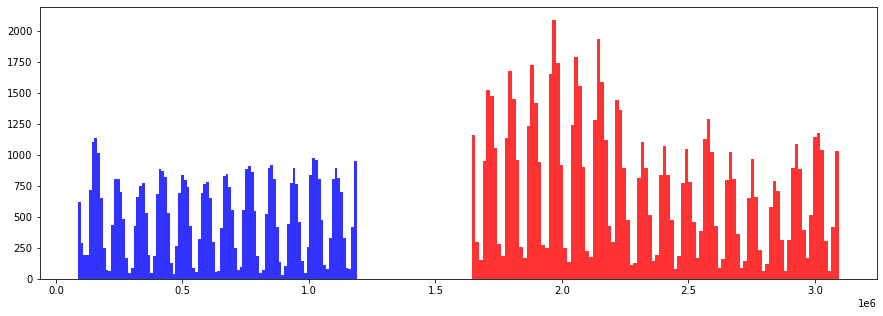

In [34]:
plt.figure(figsize=(15,5))
plt.hist(train.TransactionDT, bins=100, alpha=0.8, color="blue")
plt.hist(test.TransactionDT, bins=100, alpha=0.8, color="red")
plt.show()

In [30]:
train.TransactionDT.max(), test.TransactionDT.min()

(1189349, 1643492)

**Вывод**: 
* данные разбиты по времени, в тестовом наборе находятся данные за последующий временной период, причем видно что между тренировочным и тестовым набором есть пропуск по времени
* видно что транзакции в обоих наборах происходят примерно одинаково по времени с похожей сезонностью т.е. например транзакций больше днем чем вечером
* для таких данных как мне кажется нужно обязательно учитывать время и соот валидации делать с привязкой к времени, также возможно можно попробовать разбить на группы по сезону (например днем/вечером)

### Задание 2

построить scatter-plot зависимости суммы транзакции от времени совершения транзакции. Построить графики для обучающей выборки и для тестовой выборки, для обучающей выборки - построить как для целевой переменной = 0, так и для переменной = 1. Сделать выводы.

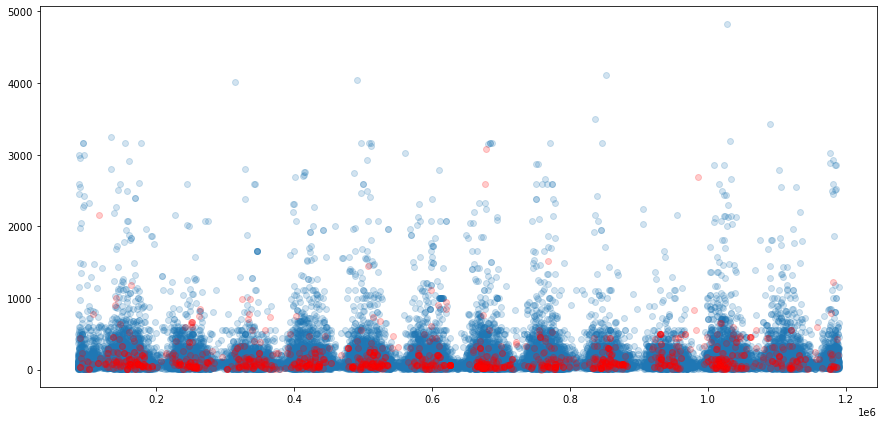

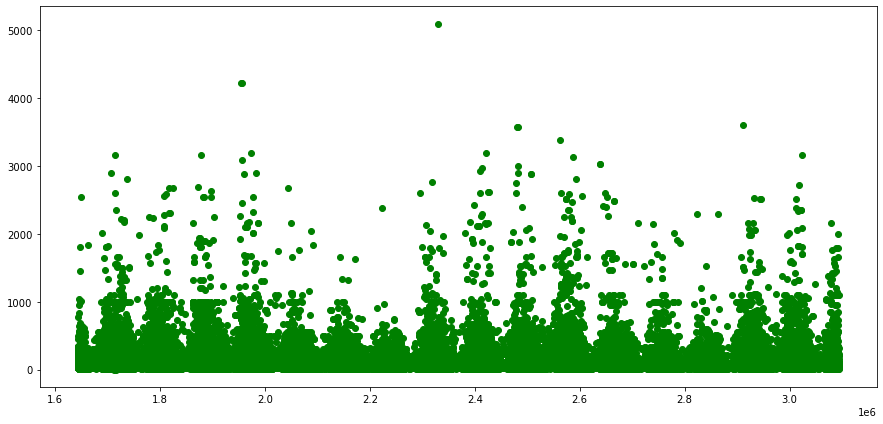

In [51]:
plt.figure(figsize=(15,7))
plt.scatter(train[train['isFraud']==0].TransactionDT, train[train['isFraud']==0].TransactionAmt, alpha=0.2)
plt.scatter(train[train['isFraud']==1].TransactionDT, train[train['isFraud']==1].TransactionAmt, alpha=0.2, 
            color="red")
plt.show()
plt.figure(figsize=(15,7))
plt.scatter(test.TransactionDT, test.TransactionAmt, color="green")
plt.show()

**Вывод**: 
* суммы транзакций что для обуч и тестовых наборов распределены похожим образом и видно что в основном покупки подороже делают в rush hours
* суммы мошеннических транзаций небольшие и также распределены больше в районе rush hours

### Задание 3

построить распределение признака TransactionAmt в логарифмическом масштабе, сделать выводы о близости распредления к нормальному распределению. Построить распределение признака в логарифмическому масштабе для обучающей выборк и для тестовой выборки, сделать выводы.

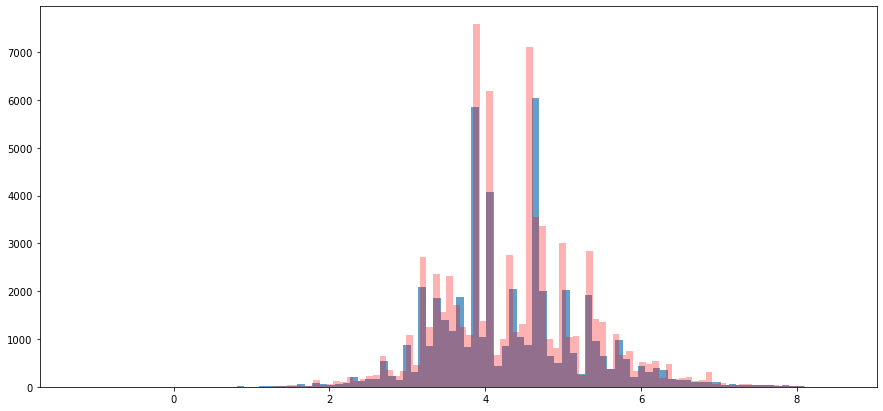

In [61]:
plt.figure(figsize=(15,7))
plt.hist(np.log(train.TransactionAmt), bins=100, alpha=0.7)
plt.hist(np.log(test.TransactionAmt), bins=100, alpha=0.3, color="red")
plt.show()

**Вывод**: 
* распределения не являются нормальными
* можно считать что тестовая и обучающая выборка по данному полю распределены одинаково

### Задание 4

построить распределение признака целевой переменной в зависимости от значений категориальных признаков ProductCD, card4, card6. Сделать выводы.

In [93]:
features = ['ProductCD', 'card4', 'card6']
gr = pd.melt(
    train,
    id_vars=["isFraud"],
    value_vars=features
)
gr['cnt'] = 1
gr = gr.pivot_table(
    index=['variable','value', 'isFraud'],
    values="cnt",
    aggfunc = 'count'
).reset_index()
gr['cnt'] = np.log(gr['cnt'])

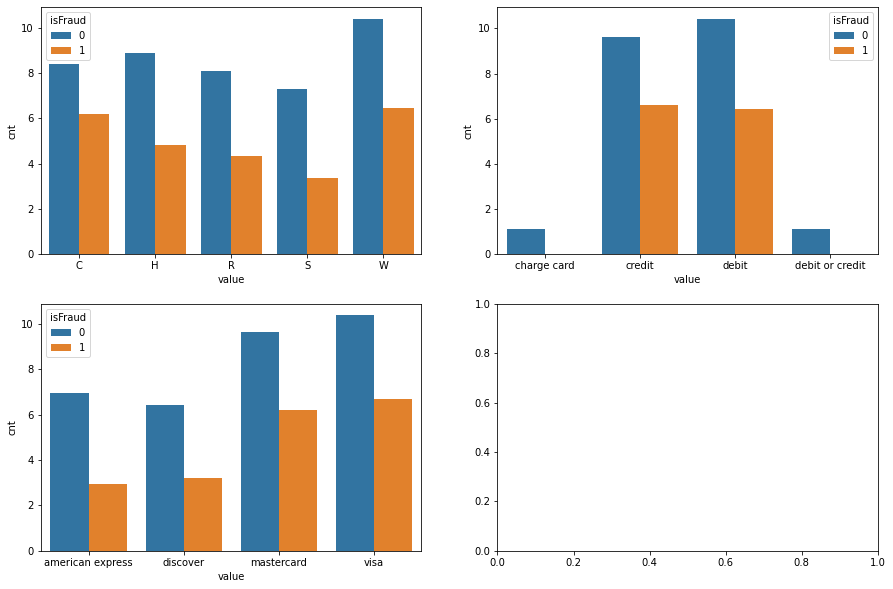

In [94]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for num, feature in enumerate(features):
    dd = gr[gr['variable']==feature]
    sns.barplot(x=dd['value'], y=dd['cnt'], hue=dd['isFraud'], orient='v', ax=axes[num%2, num//2])

**Вывод**: 
* можно считать что одинаково распределение fraud и не fraud транзакций по всем категориям

## Основное задание

Даны выборки для обучения и для тестирования. Задание заключается в том, чтобы попробовать разные способы валидации, проанализировать плюсы / минусы каждой и сделать выводы о том, какой способ валидации наиболее устойчивый в данной задаче. Метрика качества для оценки прогнозов - ROC-AUC, название целевой переменной - IsFraud. Рекомендуется использовать модели градиетного бустинга, реализация любая.

### Задание 1: сделать Hold-Out валидацию с разбиением, размер которого будет адеквтаным по вашему мнению

разбиение проводить по id-транзакции (TransactionID), обучать модель градиетного бустинга любой реализации с подбором числа деревьев по early_stopping критерию до достижения сходимости. Оценить качество модели на тестовой выборке, оценить расхождение по сравнению с качеством на обучающей выборке и тестовой выборке.

In [172]:
train.shape, test.shape

((50001, 394), (75000, 394))

In [173]:
df = train.sort_values(by='TransactionID').select_dtypes(
    include=[float, int]).drop(['TransactionID', 'TransactionDT'], axis=1)

X_test = test.select_dtypes(include=[float, int]).drop(['TransactionID', 'TransactionDT', 'isFraud'], axis=1)
y_test = test['isFraud']

X_priv = X_test.copy()
y_priv = y_test.copy()

In [174]:
div = 3*train.shape[0]//4 # 75% для train
X_train, X_valid = df[:div], df[div:]
y_train, y_valid = X_train['isFraud'], X_valid['isFraud']
X_train, X_valid = X_train.drop('isFraud', axis=1), X_valid.drop('isFraud', axis=1)

In [175]:
model = xgb.XGBClassifier(n_estimators=200)
eval_set = [(X_valid, y_valid)]
model.fit(X_train, y_train, eval_metric="auc", early_stopping_rounds=5, eval_set=eval_set, verbose=False)

XGBClassifier(n_estimators=200)

In [176]:
y_pred = model.predict_proba(X_valid)[:,1]
print(f"VALID ROC AUC: {roc_auc_score(y_valid, y_pred)}")

y_pred = model.predict_proba(X_test)[:,1]
print(f"TEST ROC AUC: {roc_auc_score(y_test, y_pred)}")

VALID ROC AUC: 0.8930378914514828
TEST ROC AUC: 0.8686351244439983


### Задание 2: сделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (TransactionID), размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1.

In [177]:
div = 3*train.shape[0]//4 # 75% для train+valid - 25% на тест
X_train, X_test = df[:div], df[div:]
y_train, y_test = X_train['isFraud'], X_test['isFraud']
X_train, X_test = X_train.drop('isFraud', axis=1), X_test.drop('isFraud', axis=1)

div = 3*X_train.shape[0]//4 # 75% для train - 25% на valid
X_train, X_valid = X_train[:div], X_train[div:]
y_train, y_valid = y_train[:div], y_train[div:]

In [178]:
X_train.shape, X_valid.shape, X_test.shape

((28125, 377), (9375, 377), (12501, 377))

In [179]:
model2 = xgb.XGBClassifier(n_estimators=200)
eval_set = [(X_valid, y_valid)]
model2.fit(X_train, y_train, eval_metric="auc", early_stopping_rounds=5, eval_set=eval_set, verbose=False)

y_pred = model2.predict_proba(X_valid)[:,1]
print(f"VALID ROC AUC: {roc_auc_score(y_valid, y_pred)}")

y_pred = model2.predict_proba(X_test)[:,1]
print(f"TEST ROC AUC: {roc_auc_score(y_test, y_pred)}")

y_pred = model2.predict_proba(X_priv)[:,1]
print(f"REAL TEST ROC AUC: {roc_auc_score(y_priv, y_pred)}")

VALID ROC AUC: 0.8303994444150173
TEST ROC AUC: 0.8395238874536806
REAL TEST ROC AUC: 0.8494667092361763


### Задание 3: построить доверительный интервал на данных из п.2 

на основе бутстреп выборок, оценить качество модели на тестовом выборке относительно полученного доверительного интервала. Сделать выводы.

In [180]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [181]:
np.random.seed(27)
scores = create_bootstrap_metrics(y_priv, model.predict(X_priv), roc_auc_score)

calculate_confidence_interval(scores)

(0.6125011638380968, 0.6317618227846877)

Text(0.5, 0, 'sample number')

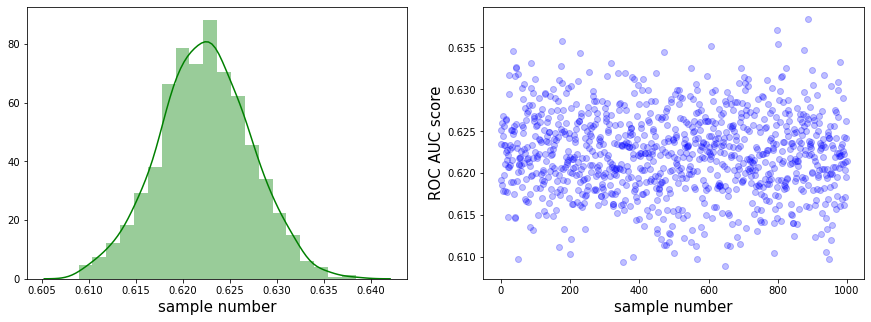

In [182]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[1].scatter(range(len(scores)), scores, alpha=0.25, color="blue")
axes[1].set_xlabel("sample number", size=15)
axes[1].set_ylabel("ROC AUC score", size=15)

sns.distplot(scores, ax=axes[0], color="green", bins=20)
axes[0].set_xlabel("sample number", size=15)

**Вывод**: 
* можно считать что модель достаточно качественная потому что разница макс/мин доверетельного интервала мала

### Задание 4: выполнить Adversarial Validation на основе данных из обучения / теста

подобрать объема из обучающей выборки, которые сильно похожи на объекты из тестовой выборки, и использовать их в качестве валидационного набора. Сделать выводы о полученных результатах.

In [183]:
X_adv = pd.concat([X_train, X_priv], axis=0)
y_adv = np.hstack((np.zeros(X_train.shape[0]), np.ones(X_priv.shape[0])))
assert X_adv.shape[0] == y_adv.shape[0]

In [185]:
ma = xgb.XGBClassifier(n_estimators=25)
ma.fit(X_adv, y_adv)
y_pred = ma.predict_proba(X_train)

pd.cut(
    y_pred[:, 1], bins=np.arange(0, 1.01, 0.1)
).value_counts().sort_index()

(0.0, 0.1]    1697
(0.1, 0.2]    4555
(0.2, 0.3]    2137
(0.3, 0.4]     893
(0.4, 0.5]     624
(0.5, 0.6]    2074
(0.6, 0.7]    3810
(0.7, 0.8]    9345
(0.8, 0.9]    2990
(0.9, 1.0]       0
dtype: int64

In [221]:
yp = y_pred[:, 1]

vf = (yp>0.7) & (yp<=0.8)
nvf = (yp<=0.7) | (yp>0.8)

xt, xv = X_train[nvf], X_train[vf]
yt, yv = y_train[nvf], y_train[vf]

In [226]:
model2 = xgb.XGBClassifier(n_estimators=200)
eval_set = [(xv, yv)]
model2.fit(xt, yt, eval_metric="auc", early_stopping_rounds=5, eval_set=eval_set, verbose=False)

y_pred = model2.predict_proba(xv)[:,1]
print(f"VALID ROC AUC: {roc_auc_score(yv, y_pred)}")

y_pred = model2.predict_proba(X_priv)[:,1]
print(f"REAL TEST ROC AUC: {roc_auc_score(y_priv, y_pred)}")

VALID ROC AUC: 0.6598050025310838
REAL TEST ROC AUC: 0.7905272091911463


**Вывод**: 
* для валидации можем взять те обьекты у которых 0.8 >= y_pred > 0.7 
* но видимо у меня не получилось :)

### Задание 5: сделать KFold / StratifiedKFold валидацию (на ваше усмотрение)

оценить получаемые качество и разброс по метрике качества. Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных;

In [228]:
X_data = train.select_dtypes(include=[float, int]).drop(['TransactionID', 'TransactionDT', 'isFraud'], axis=1)
y_data = train['isFraud']

In [237]:
model = xgb.XGBClassifier(n_estimators=100)

In [240]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

        estimator.fit(x_train, y_train)
        y_train_pred = estimator.predict_proba(x_train)[:,1]
        y_valid_pred = estimator.predict_proba(x_valid)[:,1]

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [241]:
cv_strategy = KFold(n_splits=5, random_state=1)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    X_data, y_data, model, metric=roc_auc_score, cv_strategy=cv_strategy
)

Fold: 1, train-observations = 40000, valid-observations = 10001
train-score = 0.9186, valid-score = 0.8513
Fold: 2, train-observations = 40001, valid-observations = 10000
train-score = 0.914, valid-score = 0.8698
Fold: 3, train-observations = 40001, valid-observations = 10000
train-score = 0.9058, valid-score = 0.8959
Fold: 4, train-observations = 40001, valid-observations = 10000
train-score = 0.9137, valid-score = 0.877
Fold: 5, train-observations = 40001, valid-observations = 10000
train-score = 0.9109, valid-score = 0.898
CV-results train: 0.9126 +/- 0.004
CV-results valid: 0.8784 +/- 0.017
OOF-score = 0.8765


### Задание 6 * (опциональное): сделать Hold-Out валидацию по времени (TransactionDT)

повторить процедуры из п.1 / п.2 (на ваш выбор). Построить доверительный интервал, сравнить качество на тестовой выборке с полученным доверительным интервалом. Сделать выводы.

### Задание 7 ** (совсем опциональное): в данном наборе данных у нас есть ID-транзакции (TransactionID) и время транзакции (TransactionDT)

но отсутствует ID-клиента, который совершал транзакции. Кажется, что в этой задаче валидация по клиенту работала бы хорошо. Предложить критерий, по которому можно выделить клиентов и сделать п.5, используя созданное определение клиента, используя валидацию по клиенту (GroupKFold).